In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import math as m
import random as rnd
from pathlib import Path
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


In [2]:
from utils.calibration import clalibrate_camera, getPerspectiveTransformMatrix
from utils.tresholding import get_tresholded_img

In [3]:
calibration_images = [cv2.imread('camera_cal/'+img) for img in os.listdir("camera_cal/")]
mtx, dist, rvecs, tvecs, _, _ = clalibrate_camera(calibration_images)
M,Minv = getPerspectiveTransformMatrix()

In [4]:
test_img = cv2.imread('test_images/test5.jpg')
# test_img = cv2.imread('test_images/straight_lines2.jpg')
test_img = cv2.undistort(test_img, mtx, dist, None)

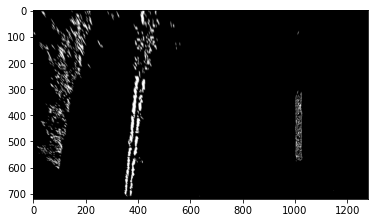

In [5]:
tresholded_img = get_tresholded_img(test_img)
warped = cv2.warpPerspective(tresholded_img,M,None)
plt.imshow(warped, cmap='gray')

In [71]:
# cv2.imshow('img',test_img)
# cv2.waitKey(500)

In [72]:

# cv2.destroyAllWindows()

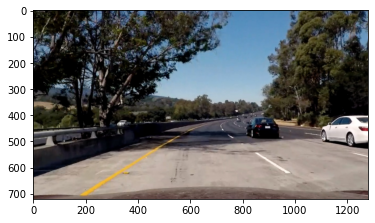

In [76]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

None
